In [1]:
%load_ext autoreload
%autoreload 2


# Identify transects

## Overview
This notebook contains two ways transects (i.e., boundaries of a chosen region) can be identified. 
<ol>
    <li> Given desired locations of points through which we want a transect to cross through, identify the consecutive edges and vertices between them. Then create a mask (i.e., find all the points that are enclosed by the transect). </li>
    <li> Given a mask, identify consecutive edges and vertices that are on the border of this mask.</li>
</ol>

In [2]:
#Packages 
import numpy as np
import xarray as xr
import cmocean.cm as cmo
import matplotlib.pyplot as plt
import mpas_tools
# from mpas_tools.planar_hex import make_planar_hex_mesh
# from mpas_tools.mesh.conversion import convert, cull, mask
# from mpas_tools.io import write_netcdf
from geometric_features import GeometricFeatures
from geometric_features import read_feature_collection

from mpas_tools.mesh.mask import compute_mpas_region_masks
from mpas_tools.parallel import create_pool
from mpas_tools.io import write_netcdf

import geojson
import json
import mosaic
import os.path
import mpasregions.sections as mps

### Set up datasets
**To create a base mask (a global "mask" filled with 1s):**
```ruby
# create a global base mask of ones everywhere. 
# We will then apply the mask where we specifically choose nCells, nVertices, and nEdges that are contained in the original mask to this basemask 
# This creates a new mask with all parts of the cell included. 


# create a base mask
mask['regionCellMasks'] = mask.regionCellMasks * 0 + 1
mask['regionVertexMasks'] = mask.regionVertexMasks * 0 + 1
mask['regionEdgeMasks'] = mask.regionEdgeMasks * 0 + 1
mask['regionNames'] = 'whole cell LS'
mask.attrs['How to use'] = 'open separate dataset with nCell, nVertices, nEdges xr index arrays. base_mask.regionCellMasks.where(base_mask.nCells.isin(cells_inside),other = 0)'
mask.to_netcdf('/global/homes/k/kuyeda/WMT_NBs/mpas-o_EC30to60_global_base_mask.nc',format='netCDF4',mode='w')
mask
```

**To convert the original mask .geojson file to a .nc file:**
```ruby
# convert geojson to .nc mask file

wmtnb_filepath = '/global/u2/k/kuyeda/WMT_NBs/'
fcMask = read_feature_collection(wmtnb_filepath + 'LS_test.geojson')
# pool = create_pool(process_count=8)
dsMasks = compute_mpas_region_masks(
    dsMesh, fcMask, maskTypes=('cell', 'vertex', 'edge'), pool=pool
)
# dsMasks.to_netcdf(wmtnb_filepath + 'LS_CEV_masks.nc', format='NETCDF4', mode='w')
```

**To switch between ID and indices** 

Code to convert between ID (called `n`) and index (called `xr`) is shown below. 
`__On__` will give `n` coordinates (IDs). \ 
`nCells/Edges/Vertices` will give `xr` coordinates (indices).

Also, just subtracting one feels easier and there is a straightforward conversion from ID (n) to index (xr) values. But the equivalent functions are below
```ruby
def xr_to_n_idx(xr):
    return xr+1
```

The equivalent conversion from  the index (xr) to ID (n) is
```ruby
cell_part = 'Cell' # 'Edge', 'Vertex'
ds = mesh
def idx_to_id(idx,cell_part,ds):
    id = ds[f'indexTo{cell_part}ID'].isel(nCells=idx).values
    return id
```

### Open necessary datasets
```mesh``` $\rightarrow$ contains information about the mesh and cells \
```dso``` $\rightarrow$ diagnostics from the simulations (datavariables we actually want to plot) \
```mask``` $\rightarrow$ a mask of 0s and 1s created from a geojson file (created using geojson.io) that was then converted into a netcdf file using ```compute_mpas_region_masks``` \
```base_mask``` $\rightarrow$ a mask of 1s for the entire globe.


In [3]:
# global mesh
mesh_path = '/global/cfs/projectdirs/e3sm/inputdata/ocn/mpas-o/EC30to60E2r2/ocean.EC30to60E2r2.210210.nc'
mesh = xr.open_dataset(mesh_path)
mesh = mesh.assign_coords({
"VertexID": xr.DataArray(mesh.indexToVertexID, dims=('nVertices',)),
})

# global data
bmm_filepath = '/pscratch/sd/b/bmoorema/run_001_062/'
dso = xr.open_dataset(bmm_filepath + '20210421_sim7_CORE_60to30E2r2.mpaso.hist.am.timeSeriesStatsMonthly.0063-12-01.nc')

# open base mask that we will fill with 0s according to the original mask (this new mask will contain cells PLUS their corresponding edges and vertices)
base_mask = xr.open_dataset('./mpas-o_EC30to60_global_base_mask.nc')


/tmp/ipykernel_1026236/638316685.py:10: FutureWarning: In a future version, xarray will not decode timedelta values based on the presence of a timedelta-like units attribute by default. Instead it will rely on the presence of a timedelta64 dtype attribute, which is now xarray's default way of encoding timedelta64 values. To continue decoding timedeltas based on the presence of a timedelta-like units attribute, users will need to explicitly opt-in by passing True or CFTimedeltaCoder(decode_via_units=True) to decode_timedelta. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  dso = xr.open_dataset(bmm_filepath + '20210421_sim7_CORE_60to30E2r2.mpaso.hist.am.timeSeriesStatsMonthly.0063-12-01.nc')


In [4]:
# set up descriptor for plotting 
# # set up mesh to apply polypcolor
mesh.attrs['is_periodic'] = 'YES'
mesh.attrs['x_period'] = 360
mesh.attrs['y_period'] = 0.0

descriptor = mosaic.Descriptor(mesh,use_latlon=False)

## Part 1: Algorithm to create transects
### Identify transect based on desired transect location

In [5]:
target_start_lon = 315
target_start_lat = 60
target_end_lon = 310
target_end_lat = 66

In [6]:
LS_lats= np.array([54, 60, 66, 64, 58])   
LS_lons= np.array([302, 315, 310, 295, 296])

LS_lats = np.append(LS_lats, LS_lats[0])
LS_lons = np.append(LS_lons, LS_lons[0])

# calculate transects from algorithm, sort vertices & edges to be in consecutive order
test_verts, test_edges = mps.calculate_transects_multiple_pts(LS_lons, LS_lats, mesh)

In [7]:
# remove the repeated vertices and edges (no backtracks)

In [8]:
# you need to remove the backtracks (this is done AFTER creating a mask file with the geojson) (so this cell will need to move down)
# for loop --> as you loop through, are there any repeats?
# if yes to repeats --> check if the edge used to id that vertex borders a cell in the mask
# if yes to bordering --> keep
# if no to bordering --> remove

In [9]:
# # assign index numbers to each of the chosen region masks to check sorted order 
# base_mask = xr.open_dataset('./mpas-o_EC30to60_global_base_mask.nc')
# base_mask['regionEdgeMasks'] = base_mask.regionEdgeMasks.where(base_mask.nEdges.isin(test_edges),other=0)
# base_mask['regionVertexMasks'] = base_mask.regionVertexMasks.where(base_mask.nVertices.isin(test_verts),other=0)

# # assign index value to sorted edges and vertices 

# modified_test_edges = test_edges[test_edges != -1]
# for i in range(0,len(modified_test_edges)):
#     base_mask.regionEdgeMasks.isel(nRegions=0)[np.int32(modified_test_edges[i])]= i

# for i in range(0,len(test_verts)):
#     base_mask.regionVertexMasks.isel(nRegions=0)[np.int32(test_verts[i])]= i

# fig,ax = plt.subplots(nrows=1,ncols=2,constrained_layout=True,figsize=(12,5))
# c = mosaic.polypcolor(ax[0],descriptor,
#                   base_mask.regionEdgeMasks.isel(nRegions=0),cmap='viridis',
#                   antialiaseds=False)

# d = mosaic.polypcolor(ax[1],descriptor,
#                   base_mask.regionVertexMasks.isel(nRegions=0),cmap='viridis',
#                   antialiaseds=False)

# ax[0].set_title('Sorted Edges')
# ax[1].set_title('Sorted Vertices')

# # LS
# for i in range(0,2):
#     ax[i].set_xlim(290, 318)
#     ax[i].set_ylim(51.5, 68)

# fig.suptitle('Transect from Algorithm')

## Create a geojson file using the vertex lats and lons we just found. Then create a mask for all the points contained by this transect.

In [10]:
# get the lats and lons of the test_verts to use for creation of a geojson file
test_verts_lats = mesh.latVertex.isel(nVertices = np.int32(test_verts)) * 180 / np.pi 
test_verts_lons = mesh.lonVertex.isel(nVertices = np.int32(test_verts)) * 180 / np.pi - 360

test_verts_lonslats = np.array([test_verts_lons,test_verts_lats]).T
list_test_verts_lonslats = test_verts_lonslats.tolist()

In [11]:
# check if the geojson mask file created from a transect algorithm exists
path = './'
filename = 'LS_test'
alg_filename = filename + '_transect_from_alg'

check_alg_geojson_existence = os.path.isfile(path + alg_filename + '.geojson')

if check_alg_geojson_existence == True:
    print(f'{alg_filename}.geojson exists!')
else:
    print('Creating geojson file from vertices identified with transect algorithm')
    
    transect_from_alg = {
        "type": "FeatureCollection",
        "features": [{
            "type": "Feature",
            "properties":{
                "name":"Labrador Sea from transect algorithm",
                "tags":"Labrador_Sea;Davis_Strait",
                "object":"region",
                "component":"ocean",
                "author":"Kaila Uyeda"
            },
            "geometry": {
                "coordinates":[list_test_verts_lonslats],
                "type": "Polygon"
            }
        }]
    }

    filepath = './'
    # save to a geojson file
    # with = open and then close
    # w = write mode
    
    with open(filepath + f'{alg_filename}.geojson','w') as f:
        geojson.dump(transect_from_alg, f, indent=2)

    
# check if the .nc mask file created from a transect algorithm exists
check_alg_nc_existence = os.path.isfile(path + alg_filename + '.nc')
check_alg_nc_existence == False

if check_alg_nc_existence == True:
    print(f'Opening {alg_filename}.nc as dsMasks')
    dsMasks = xr.open_dataset(path + alg_filename + '.nc')
else:
    print('Creating netcdf mask file from geojson file (vertices identified from transect algorithm)')
    fcMask = read_feature_collection(path + alg_filename + '.geojson')
    # pool = create_pool(process_count=8)
    dsMasks = compute_mpas_region_masks(mesh, fcMask, maskTypes=('cell',), pool=pool)
    dsMasks.to_netcdf(path + alg_filename + '.nc', format='NETCDF4', mode='w')
    dsMasks = xr.open_dataset(path + alg_filename + '.nc')
    print(f'{alg_filename}.nc created and opened as dsMasks')
    


LS_test_transect_from_alg.geojson exists!
Opening LS_test_transect_from_alg.nc as dsMasks


In [12]:
# create cellmasks (which cells centers are included in the masked region)
cellmask = dsMasks.regionCellMasks.isel(nRegions=0).astype(bool)

(51.5, 68.0)

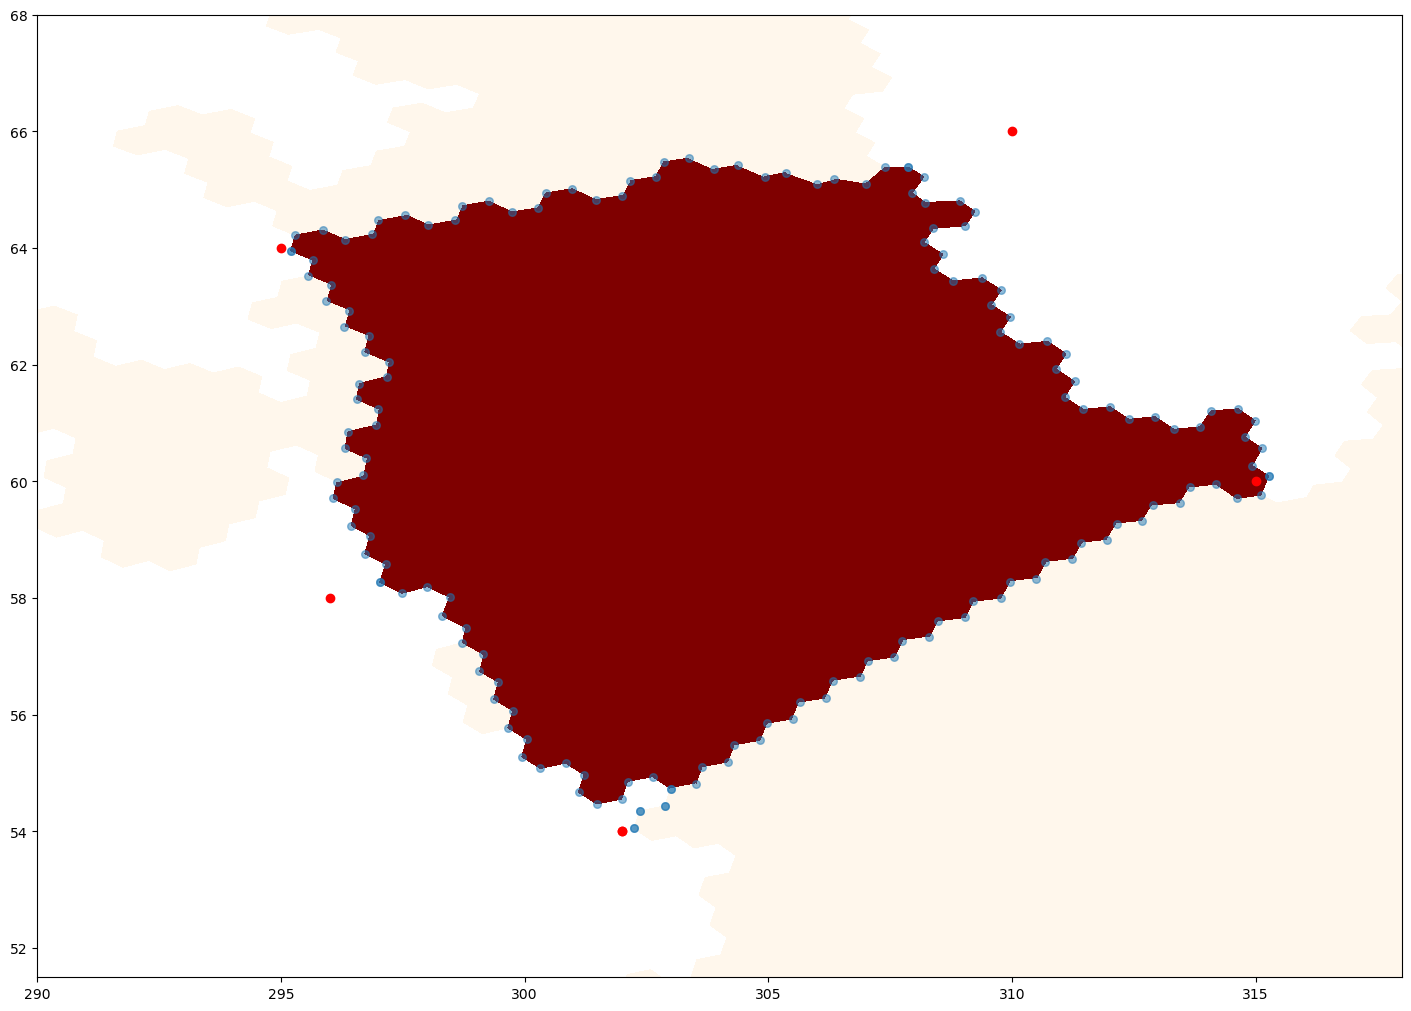

In [13]:
# plot this masked region
fig,ax = plt.subplots(nrows=1,ncols=1,constrained_layout=True,figsize=(14,10))

# plot the cellmask created from the cell centers in the mask (id'd with MPAS-tools)
c = mosaic.polypcolor(ax,descriptor,
                  cellmask.astype(int),cmap='OrRd',
                  antialiaseds=False)

# fig.colorbar(c, extend='both')

# LS (lats and lons of vertices from transect)
ax.scatter(test_verts_lons + 360,test_verts_lats, alpha=0.5, s=30)

# LS the target start and end points when creating the algorithm
ax.plot(LS_lons, LS_lats, "ro")


ax.set_xlim(290, 318)
ax.set_ylim(51.5, 68)

#fig.suptitle('Grid variables from mask made from transect algorithm + MPAS-Tools')

In [ ]:
mesh

NameError: name 'edgemask' is not defined

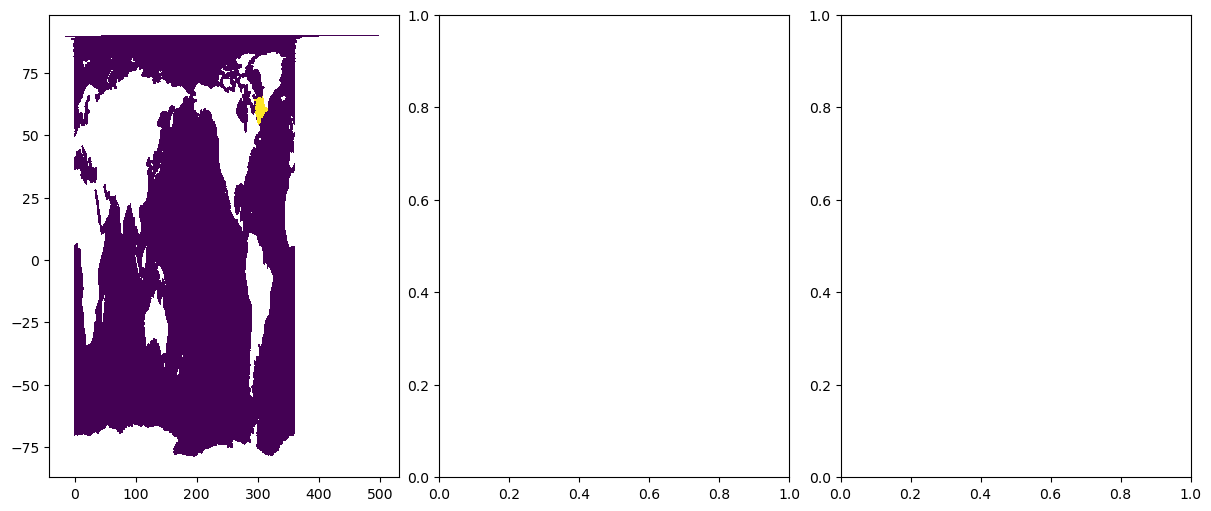

In [39]:
# # plot this masked region
# fig,ax = plt.subplots(nrows=1,ncols=3,constrained_layout=True,figsize=(12,5))

# new_cmap = plt.get_cmap('viridis')
# new_cmap.set_under('magenta')

# c = mosaic.polypcolor(ax[0],descriptor,
#                   cellmask.astype(int),cmap='viridis',
#                   antialiaseds=False)
# d = mosaic.polypcolor(ax[1],descriptor,
#                   edgemask.astype(int),cmap='viridis',
#                   antialiaseds=False)
# e = mosaic.polypcolor(ax[2],descriptor,
#                   vertexmask.astype(int),cmap='viridis',
#                   antialiaseds=False)

# # fig.colorbar(c, extend='both')

# # LS
# for i in range(0,3):
#     ax[i].set_xlim(290, 318)
#     ax[i].set_ylim(51.5, 68)

# ax[0].set_title('Cells')
# ax[1].set_title('Edges')
# ax[2].set_title('Vertices')
# fig.suptitle('Grid variables from mask made from transect algorithm + MPAS-Tools')

the mismatch between the length of the `test_verts_lons` (creating geojson file from alg transect) and the `vertex_lons` (vertices in the .nc file made from the geojson file) makes me feel like something is wrong... To which grid coordinate do the geojson lats and lons get assigned? They are using the same points (`len(np.intersect1d(test_verts_lons + 360, vertex_lons))` is equal to the length of `vertex_lons`, but I don't understand why there are `len(test_verts_lons)-len(vertex_lons)` = 15 missing points. 

In [ ]:
alg_edges, alg_vertices = mps.xr_sorted_transect_edges_and_vertices(mesh,dsMasks)

In [ ]:
len(test_verts_lons)

In [ ]:
len(alg_vertices)

In [ ]:
# plot using vertex lats and lons
vertex_lons = mesh.lonVertex.isel(nVertices = alg_vertices) * 180 / np.pi
vertex_lats = mesh.latVertex.isel(nVertices = alg_vertices) * 180 / np.pi

# plot using edge lats and lons
edge_lons = mesh.lonEdge.isel(nEdges = alg_edges) * 180 / np.pi
edge_lats = mesh.latEdge.isel(nEdges = alg_edges) * 180 / np.pi

fig,ax = plt.subplots(nrows=1,ncols=2,constrained_layout=True,figsize=(12,5))
v = ax[0].scatter(vertex_lons, vertex_lats,marker='.',label='vertices')
v.set_sizes([10])
ax[0].plot(edge_lons,edge_lats,color='red',label='edges')

ax[1].plot(vertex_lons, vertex_lats, marker='.')
s = ax[1].scatter(edge_lons,edge_lats,color='red',marker='x')
s.set_sizes([10])
ax[0].legend()

fig.suptitle('Sorted vertex & edge locations')

<div class="alert alert-warning" role="alert">
  <b>END OF TRANSECT CREATION FROM ALGORITHM </b> 
</div>


# Part 2: Mask to create transects

In [38]:
# open mask of desired region (this is to find transects from a pre-existing mask)

path = './'
filename = 'LS_test_transect_from_mask'

check_nc_existence = os.path.isfile(path + filename + '.nc')

# check if .nc mask file exists
if check_nc_existence == True:
    print(f'Opening {filename}.nc file')
    mask = xr.open_dataset(path + filename + '.nc')
else: 
    print('Creating .nc file')
    check_geojson_existence = os.path.isfile(path + filename + '.geojson')

    # convert LS_test.geojson to LS_test.nc mask file
    if check_geojson_existence == True:
        print(f'Using {filename}.geojson to create .nc file')
        fcMask = read_feature_collection(path + filename + '.geojson')
        # pool = create_pool(process_count=8)
        dsMasks = compute_mpas_region_masks(mesh, fcMask, maskTypes =('cell',), pool=pool)
        dsMasks.to_netcdf(path + filename + '.nc', format='NETCDF4', mode='w')
        mask = xr.open_dataset(path + filename + '.nc')
        print(f'{filename}.nc created and opened as masks')
    else:
        print(f'{filename}.geojson does NOT exist!')


Creating .nc file
Using LS_test_transect_from_mask.geojson to create .nc file
LS_test_transect_from_mask.nc created and opened as masks


In [ ]:
next_edges, next_vertices = mps.xr_sorted_transect_edges_and_vertices(mesh,mask)

In [ ]:
base_mask = xr.open_dataset('./mpas-o_EC30to60_global_base_mask.nc')
# LS
base_mask['regionEdgeMasks'] = base_mask.regionEdgeMasks.where(base_mask.nEdges.isin(next_edges),other=0)
base_mask['regionVertexMasks'] = base_mask.regionVertexMasks.where(base_mask.nVertices.isin(next_vertices),other=0)

for i in range(0,len(next_edges)):
    base_mask.regionEdgeMasks.isel(nRegions=0)[np.int32(next_edges[i])]= i+1

for i in range(0,len(next_edges)):
    base_mask.regionVertexMasks.isel(nRegions=0)[np.int32(next_vertices[i])]= i+1


fig,ax = plt.subplots(nrows=1,ncols=2,constrained_layout=True,figsize=(12,5))

new_cmap = plt.get_cmap('viridis')
new_cmap.set_under('magenta')

c = mosaic.polypcolor(ax[0],descriptor,
                  base_mask.regionEdgeMasks.isel(nRegions=0),cmap=new_cmap,vmin=1,
                  antialiaseds=False)

d = mosaic.polypcolor(ax[1],descriptor,
                  base_mask.regionVertexMasks.isel(nRegions=0),cmap=new_cmap,vmin=1,
                  antialiaseds=False)


# LS
for i in range(0,2):
    ax[i].set_xlim(290, 318)
    ax[i].set_ylim(51.5, 68)

ax[0].set_title('Sorted edges')
ax[1].set_title('Sorted vertices')

fig.suptitle('Transect from Mask')

In [ ]:
# plot using vertex lats and lons
vertex_lons = mesh.lonVertex.isel(nVertices = next_vertices) * 180 / np.pi
vertex_lats = mesh.latVertex.isel(nVertices = next_vertices) * 180 / np.pi

# plot using edge lats and lons
edge_lons = mesh.lonEdge.isel(nEdges = np.int32(next_edges)) * 180 / np.pi
edge_lats = mesh.latEdge.isel(nEdges = np.int32(next_edges)) * 180 / np.pi

fig,ax = plt.subplots(nrows=1,ncols=2,constrained_layout=True,figsize=(12,5))
v = ax[0].scatter(vertex_lons, vertex_lats,marker='.',label='vertices')
v.set_sizes([10])
ax[0].plot(edge_lons,edge_lats,color='red',label='edges')

ax[1].plot(vertex_lons, vertex_lats, marker='.')
s = ax[1].scatter(edge_lons,edge_lats,color='red',marker='x')
s.set_sizes([10])
ax[0].legend()

fig.suptitle('Sorted vertex & edge locations')